# Project: 멋진 챗봇 만들기

- 라이브러리 버전을 확인해 봅니다
- 사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import numpy 
import pandas 
import tensorflow 
import nltk
import gensim

print(numpy.__version__)
print(pandas.__version__)
print(tensorflow.__version__)
print(nltk.__version__)
print(gensim.__version__)

1.21.4
1.3.3
2.6.0
3.6.5
3.8.3


In [2]:
import os
import re

import pandas as pd
import numpy as np

import tensorflow as tf

In [3]:
from tqdm import tqdm, trange

## Step 1. 데이터 다운로드
준비하기 단계에서 심볼릭 링크를 생성했다면 아래 파일이 ChatbotData .csv라는 이름으로 저장되어 있을거예요. csv 파일을 읽는 데에는 pandas 라이브러리가 적합합니다. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장하세요!

- songys/Chatbot_data

In [4]:
chatbot = pd.read_csv('./data/ChatbotData.csv')

In [5]:
questions = chatbot.Q.tolist()
answers = chatbot.A.tolist()

In [6]:
chatbot

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


## Step 2. 데이터 정제
아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요.

1. 영문자의 경우, 모두 소문자로 변환합니다.
1. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!

In [7]:
# 전처리 함수
def preprocess_sentence(sentence, num=True):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 숫자 사이에도 거리를 만들어준다
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+)", r" \1 ", sentence)
    #sentence = re.sub(r'[" "]+', " ", sentence)

    # (가-힣, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    if num == False: # 숫자제거
        sentence = re.sub(r'[^가-힣a-zA-Z.?!,]', ' ', sentence)
    else:
        sentence = re.sub(r'[^가-힣0-9a-zA-Z.?!,]', ' ', sentence)
        
    sentence = ' '.join(sentence.split())
    sentence = sentence.strip()
    return sentence

In [8]:
sentence = '3박4일 놀러가고 싶다'
preprocess_sentence(sentence, False)

'박 일 놀러가고 싶다'

In [9]:
preprocess_sentence(sentence, True)

'3 박 4 일 놀러가고 싶다'

In [10]:
questions = [preprocess_sentence(question, True) for question in questions]
answers = [preprocess_sentence(answer, True) for answer in answers]

In [11]:
print(questions[0])
print(answers[0])

12 시 땡 !
하루가 또 가네요 .


## Step 3. 데이터 토큰화
---
토큰화에는 KoNLPy의 `mecab` 클래스를 사용합니다.

아래 조건을 만족하는 `build_corpus()` 함수를 구현하세요!

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
2. 데이터를 앞서 정의한 `preprocess_sentence()` 함수로 정제하고, 토큰화합니다.
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 `mecab.morphs` 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 `questions` 와 `answers` 를 각각 `que_corpus`, `ans_corpus` 에 토큰화하여 저장합니다.

In [12]:
from konlpy.tag import Mecab

In [13]:
mecab = Mecab()

In [14]:
q = [mecab.morphs(question) for question in questions]
a = [mecab.morphs(answer) for  answer in  answers]

In [15]:
np.unique([l for l in q if len(l) <= 1])

array(['건방져', '겁난다', '고백', '괴로워', '굿모닝', '그리움', '기다림', '꿈', '나그네', '넋두리',
       '눈물', '단수', '답답증', '더워', '덤덤', '뜬금없이', '마무리', '멘붕', '무상', '무서워요',
       '무제', '미련', '미워', '미워한다', '미쳐', '바람', '반가워', '받아들여야지', '배고파',
       '배불러', '변명', '분노', '불면증', '비트코인', '사진첩', '살아간다', '상념', '상처', '새벽',
       '속상해', '술주정', '스트레스', '시련', '심심', '싱숭생숭', '쓰레기', '씁쓸', '아파', '안녕',
       '야', '양다리', '어머', '어머나', '어째서', '에이씨', '에휴', '연휴', '오지마', '왜',
       '외로움', '외로워', '외로워서', '으악', '으흠', '음', '응', '이놈', '이별', '이혼', '인내',
       '인연', '자괴감', '잘래', '잠수', '저기', '젠장', '조심조심', '졸려', '주저리주저리', '증오',
       '지친다', '짝사랑', '착각', '첫눈', '최악', '추워', '침묵', '코자', '콜록콜록', '통증',
       '파혼', '핑계', '한숨', '허기져', '헉', '헤어짐', '혼자', '후', '후우', '후회', '휴',
       '흔적', '흠'], dtype='<U6')

In [16]:
np.unique([l for l in a if len(l) <= 1])

array(['꼬르륵', '네', '사랑', '아이구', '어머나', '음', '킁킁', '토닥토닥', '휴우'],
      dtype='<U4')

In [17]:
def get_token_len(token_list, max_tokens=None, hist=False):
    num_tokens = [len(tokens) for tokens in token_list]
    num_tokens = np.array(num_tokens)

    # 평균값, 최댓값, 표준편차
    print(f"토큰 길이 평균: {np.mean(num_tokens)}")
    print(f"토큰 길이 최소: {np.min(num_tokens)}")
    print(f"토큰 길이 최대: {np.max(num_tokens)}")
    print(f"토큰 길이 표준편차: {np.std(num_tokens)}")
    
    if max_tokens==None:
        max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    print(f'설정 최대 길이: {maxlen}')
    ratio = np.sum(num_tokens < max_tokens) / len(num_tokens) * 100
    print(f'전체 문장의 {round(ratio, 1)}%가 설정값인 {maxlen}에 포함됩니다.')
    
    if hist:
        plt.hist(num_tokens, bins=50)
        plt.axvline(maxlen, color='r', linestyle='dashed', linewidth=1)
        plt.xlabel('length of samples')
        plt.ylabel('number of samples')
        plt.title('Distribution of token lengths')
        plt.show();

In [18]:
import matplotlib.pyplot as plt

토큰 길이 평균: 7.020806901801573
토큰 길이 최소: 1
토큰 길이 최대: 32
토큰 길이 표준편차: 3.520086289509423
설정 최대 길이: 15
전체 문장의 95.9%가 설정값인 15에 포함됩니다.


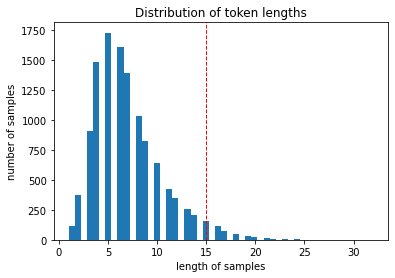

In [19]:
get_token_len(q, max_tokens=15, hist=True)

토큰 길이 평균: 8.37739998308382
토큰 길이 최소: 1
토큰 길이 최대: 40
토큰 길이 표준편차: 3.576072915130701
설정 최대 길이: 15
전체 문장의 95.9%가 설정값인 15에 포함됩니다.


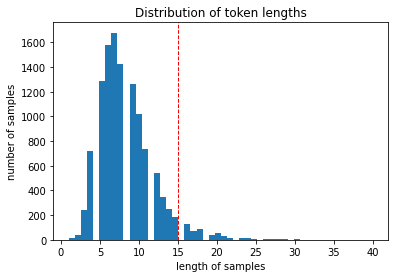

In [20]:
get_token_len(a, max_tokens=None, hist=True)

In [21]:
def drop_empty_list(que_corpus, ans_corpus):    
    drop_que = [index for index, sentence in enumerate(que_corpus) 
                if (len(sentence) > 15)|(len(sentence) <= 1)]
    print(f'제거하고자 하는 한글 샘플 수 : {len(drop_que)}')
    
    drop_ans = [index for index, sentence in enumerate(ans_corpus) 
                if (len(sentence) > 15)|(len(sentence) <= 1)]
    print(f'제거하고자 하는 영어 샘플 수 : {len(drop_ans)}')
    
    drop_data = set(drop_que) | set(drop_ans)
    drop_data = list(drop_data)
    print(f'제거하고자 하는 총 샘플 수 : {len(drop_data)}')

    # 빈 샘플 제거
    que_corpus = np.delete(que_corpus, drop_data, axis=0)
    ans_corpus = np.delete(ans_corpus, drop_data, axis=0)
    print(f'빈 샘플 제거 후 남은 kor_corpus data : {len(que_corpus)}')
    print(f'빈 샘플 제거 후 남은 eng_corpus data : {len(ans_corpus)}')
    return que_corpus, ans_corpus

In [22]:
def build_corpus(questions, answers, tokenizer):
    
    que_corpus = [tokenizer.morphs(question) for question in questions]
    ans_corpus = [tokenizer.morphs(answer) for answer in  answers]
    
    assert len(que_corpus) == len(ans_corpus)

    return drop_empty_list(que_corpus, ans_corpus)

In [23]:
mecab = Mecab()

In [24]:
que_corpus, ans_corpus = build_corpus(questions, answers, mecab)

제거하고자 하는 한글 샘플 수 : 445
제거하고자 하는 영어 샘플 수 : 503
제거하고자 하는 총 샘플 수 : 914
빈 샘플 제거 후 남은 kor_corpus data : 10909
빈 샘플 제거 후 남은 eng_corpus data : 10909


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## Step 4. Augmentation
---
우리에게 주어진 데이터는 1만 개가량으로 적은 편에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? Lexical Substitution을 실제로 적용해 보도록 하겠습니다.

아래 링크를 참고하여 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다. Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!

- Kyubyong/wordvectors
다운로드한 모델을 활용해 데이터를 Augmentation 하세요! 앞서 정의한 `lexical_sub()` 함수를 참고하면 도움이 많이 될 겁니다.

Augmentation된 `que_corpus` 와 원본 `ans_corpus` 가 병렬을 이루도록, 이후엔 반대로 원본 `que_corpus` 와 Augmentation된 `ans_corpus` 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

In [25]:
# !pip install gensim==3.8.3

In [26]:
import gensim
from gensim.models import KeyedVectors
import random

In [27]:
# Word2Vec 모델 로드
model = gensim.models.Word2Vec.load('./data/ko.bin')

In [28]:
model.wv.most_similar('오늘', topn=10)

[('아침', 0.5024495124816895),
 ('저물', 0.455463707447052),
 ('내일', 0.4449270963668823),
 ('지금', 0.4403955936431885),
 ('새벽', 0.4366644620895386),
 ('토요일', 0.40253746509552),
 ('저녁', 0.3899332880973816),
 ('어제', 0.38877636194229126),
 ('매주', 0.3823928236961365),
 ('주말', 0.3814442753791809)]

In [29]:
def lexical_sub(corpus, model=model, topn=10):
    
    # 모델에 있는 단어들만 골라내기
    words_in_model = [word for word in corpus if (word in model.wv) & (len(word) > 1)]
    
    if not words_in_model:
        return corpus
    
    # 모델에 있는 단어 중 하나를 무작위로 선택
    selected_word = random.choice(words_in_model)
    #print(f"선택된 단어: {selected_word}")

    # 유사한 단어들을 topn 개수만큼 가져오기
    similar_words = model.wv.most_similar(selected_word, topn=topn)
    
    # 유사한 단어 중 하나를 무작위로 선택
    similar_word = random.choice(similar_words)[0]
    
    # 선택된 단어를 유사한 단어로 대체
    new_sentence = [similar_word if word == selected_word else word for word in corpus]

    return new_sentence

# 예시 문장
corpus = que_corpus[1]
augmented_sentence = lexical_sub(corpus)
print("원본 문장:", corpus)
print("변형된 문장:", augmented_sentence)

원본 문장: ['1', '지망', '학교', '떨어졌', '어']
변형된 문장: ['1', '진학', '학교', '떨어졌', '어']


In [30]:
def augment_data(que_corpus, ans_corpus):
    print('Augment Data ...')
    augmented_que_corpus = [lexical_sub(sentence) for sentence in que_corpus]
    augmented_ans_corpus = [lexical_sub(sentence) for sentence in ans_corpus]
    #print('Done!')
    augmented_pairs = []
    
    print('Making Pairs ...')
    # 원본 질문 - 증강 답변
    for que, aug_ans in tqdm(zip(que_corpus, augmented_ans_corpus)):
        augmented_pairs.append((que, aug_ans))

    # 증강 질문 - 원본 답변
    for aug_que, ans in tqdm(zip(augmented_que_corpus, ans_corpus)):
        augmented_pairs.append((aug_que, ans))

    # 증강 질문 - 증강 답변
    for aug_que, aug_ans in tqdm(zip(augmented_que_corpus, augmented_ans_corpus)):
        augmented_pairs.append((aug_que, aug_ans))

    return augmented_pairs

In [31]:
augmented_pairs = augment_data(que_corpus, ans_corpus)

Augment Data ...
Making Pairs ...


10909it [00:00, 519850.28it/s]
10909it [00:00, 591097.33it/s]
10909it [00:00, 687951.62it/s]


In [32]:
# 결과 출력
for pair in augmented_pairs[:4]:
    print(f"질문: {pair[0]} \t 답변: {pair[1]}")

질문: ['12', '시', '땡', '!'] 	 답변: ['후미', '가', '또', '가', '네요', '.']
질문: ['1', '지망', '학교', '떨어졌', '어'] 	 답변: ['통곡', '해', '드립니다', '.']
질문: ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'] 	 답변: ['여행', '은', '기분', '좋', '죠', '.']
질문: ['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다'] 	 답변: ['여행', '은', '반드시', '좋', '죠', '.']


## Step 5. 데이터 벡터화
타겟 데이터인 `ans_corpus` 에 `<start>` 토큰과 `<end>` 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 `ans_corpus` 는 `list` 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!

In [33]:
sample_data = ["12", "시", "땡", "!"]

print(["<start>"] + sample_data + ["<end>"])

['<start>', '12', '시', '땡', '!', '<end>']


In [34]:
augmented_pairs[:10]

[(['12', '시', '땡', '!'], ['후미', '가', '또', '가', '네요', '.']),
 (['1', '지망', '학교', '떨어졌', '어'], ['통곡', '해', '드립니다', '.']),
 (['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
  ['여행', '은', '기분', '좋', '죠', '.']),
 (['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다'],
  ['여행', '은', '반드시', '좋', '죠', '.']),
 (['PPL', '심하', '네'], ['눈살', '이', '찌푸려', '지', '죠', '.']),
 (['SD', '카드', '망가졌', '어'], ['다시', '새롭', '사', '는', '게', '마음', '편해요', '.']),
 (['SD', '카드', '안', '돼'], ['다시', '새로', '사', '는', '게', '믿음', '편해요', '.']),
 (['SNS', '맞', '팔', '왜', '안', '하', '지'],
  ['잘', '알아보', '고', '있', '을', '수', '도', '있', '어요', '.']),
 (['SNS', '시간', '낭비', '인', '거', '아', '는데', '매일', '하', '는', '중'],
  ['시간', '을', '정하', '고', '해', '보', '소서', '.']),
 (['SNS', '시간', '낭비', '인데', '자꾸', '보', '게', '됨'],
  ['간격', '을', '정하', '고', '해', '보', '세요', '.'])]

In [35]:
que_corpus_aug = [pair[0] for pair in augmented_pairs]
ans_corpus_aug = [pair[1] for pair in augmented_pairs]

In [36]:
ans_corpus_aug

[['후미', '가', '또', '가', '네요', '.'],
 ['통곡', '해', '드립니다', '.'],
 ['여행', '은', '기분', '좋', '죠', '.'],
 ['여행', '은', '반드시', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.'],
 ['다시', '새롭', '사', '는', '게', '마음', '편해요', '.'],
 ['다시', '새로', '사', '는', '게', '믿음', '편해요', '.'],
 ['잘', '알아보', '고', '있', '을', '수', '도', '있', '어요', '.'],
 ['시간', '을', '정하', '고', '해', '보', '소서', '.'],
 ['간격', '을', '정하', '고', '해', '보', '세요', '.'],
 ['자랑', '하', '는', '자리', 'ㅂ니까', '.'],
 ['그', '백성', '도', '그럴', '거', '예요', '.'],
 ['그', '손님', '도', '그럴', '거', '예요', '.'],
 ['혼자', '를', '춤추', '세요', '.'],
 ['돈', '은', '드디어', '들어올', '거', '예요', '.'],
 ['땀', '을', '식혀', '주', '일일이', '.'],
 ['어서', '잊', '고', '새', '발원', '하', '세요', '.'],
 ['빨리', '집', '에', '돌아가', '서', '끄', '고', '나오', 'ㅂ시다', '.'],
 ['늦', '집', '에', '돌아가', '서', '끄', '고', '나오', '세요', '.'],
 ['다음', '달', '에', '는', '더', '낭비', '해', '봐요', '.'],
 ['서늘', '하', '게', '사세요', '!'],
 ['아래', '달', '에', '는', '더', '절약', '해', '봐요', '.'],
 ['온', '가족', '이', '모두', '마음', '에', '드', '는', '곳', '으로', '가', '보

In [37]:
enc_train = np.concatenate((que_corpus, que_corpus_aug), axis=0)
dec_train = np.concatenate((ans_corpus, ans_corpus_aug), axis=0)

dec_train = [["<start>"] + sentence + ["<end>"] for sentence in dec_train]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [38]:
num_words = None

In [39]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words)

In [40]:
corpus = np.concatenate((enc_train, dec_train), axis=0).tolist()

In [41]:
tokenizer.fit_on_texts(corpus)

In [42]:
len(tokenizer.word_index)

9939

In [43]:
enc_train = tokenizer.texts_to_sequences(enc_train)
dec_train = tokenizer.texts_to_sequences(dec_train)

MAX_LEN = 17
enc_train = tf.keras.preprocessing.sequence.pad_sequences(enc_train, maxlen=MAX_LEN, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(dec_train, maxlen=MAX_LEN, padding='post')

In [44]:
enc_train

array([[2477,  152, 3796, ...,    0,    0,    0],
       [ 250, 3797,  567, ...,    0,    0,    0],
       [ 263, 2478,  572, ...,    0,    0,    0],
       ...,
       [6783,   13,   51, ...,    0,    0,    0],
       [ 183, 1282,   15, ...,    0,    0,    0],
       [1348,  291,  174, ...,    0,    0,    0]], dtype=int32)

In [45]:
enc_train.shape, dec_train.shape

((43636, 17), (43636, 17))

In [46]:
enc_train[:5]

array([[2477,  152, 3796,   70,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 250, 3797,  567,  939,    9,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 263, 2478,  572,   54,  182,  216,    7,   10,   33,   27,    0,
           0,    0,    0,    0,    0,    0],
       [ 263, 2478,  572,   54,  530,  182,  216,    7,   10,   33,   27,
           0,    0,    0,    0,    0,    0],
       [5471, 1125,   34,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

## Step 6. 훈련하기
앞서 번역 모델을 훈련하며 정의한 Transformer 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! 가장 멋진 답변과 모델의 하이퍼파라미터를 제출하시면 됩니다.

In [47]:
# Positional Encoding 구현

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights
    
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out
    
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn
    
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn
    
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns
    
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
    
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [48]:
# Learning Rate Scheduler 구현

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
    
# Learning Rate 인스턴스 선언 & Optimizer 구현
D_MODEL = 256
learning_rate = LearningRateScheduler(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [49]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
            model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [50]:
D_MODEL = 256
N_LAYERS = 2
N_HEADS = 8
D_FF = 1024
POS_LEN = MAX_LEN
DROPOUT = 0.3

In [51]:
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [52]:
tf.keras.backend.clear_session()

# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers = N_LAYERS,
    d_model = D_MODEL,
    n_heads = N_HEADS,
    d_ff = D_FF,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=POS_LEN,
    dropout=DROPOUT,
    shared_fc=False,
    shared_emb=False)

In [53]:
enc_train.shape, dec_train.shape

((43636, 17), (43636, 17))

In [54]:
def translate(sentence, model, tokenizer):
    sos_idx = tokenizer.word_index['<start>']
    eos_idx = tokenizer.word_index['<end>']

    sentence = preprocess_sentence(sentence)

    m = Mecab()
    sentence = m.morphs(sentence)

    _input = tokenizer.texts_to_sequences([sentence])
    _input = tf.keras.preprocessing.sequence.pad_sequences(
        _input,
        maxlen=MAX_LEN,
        padding='post'
    )

    ids = []
    output = tf.expand_dims([sos_idx], 0)

    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output
        )

        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            _input, output, enc_padding_mask, combined_mask, dec_padding_mask
        )

        predicted_id = tf.argmax(
            tf.math.softmax(predictions, axis=-1)[0, -1]
        ).numpy().item()

        if predicted_id == eos_idx:
            result = tokenizer.sequences_to_texts([ids])
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tokenizer.sequences_to_texts([ids])
    return result

In [55]:
def translate_vect(sentence, model, tokenizer):
    sos_idx = tokenizer.word_index['<start>']
    eos_idx = tokenizer.word_index['<end>']

    _input = sentence.reshape(1,-1)

    ids = []
    output = tf.expand_dims([sos_idx], 0)

    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output
        )

        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            _input, output, enc_padding_mask, combined_mask, dec_padding_mask
        )

        predicted_id = tf.argmax(
            tf.math.softmax(predictions, axis=-1)[0, -1]
        ).numpy().item()

        if predicted_id == eos_idx:
            result = tokenizer.sequences_to_texts([ids])
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tokenizer.sequences_to_texts([ids])
    return result

In [56]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 50

examples = [
            "지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."
]

translates = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
        
    results = []
    for example in examples:
        ans = translate(example, transformer, tokenizer)[0]
        results.append(ans)
        print(f"Question: {example:<30}\tAnswer: {ans:<30}")
        
    translates.append(results)

/tmp/ipykernel_2314/3863982956.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 사랑 은 사랑 이 에요 .                
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 사랑 은 사랑 이 에요 .                
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 사랑 은 사랑 이 에요 .                
Question: 집에 있는다는 소리야.                  	Answer: 잘 하 는 게 좋 을 거 예요 .            


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 저 도 요 .                       
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 좋 은 건강 이 네요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 좋 은 마음 이 흘렀 네요 .              
Question: 집에 있는다는 소리야.                  	Answer: 좋 은 기억 이 네요 .                 


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 같이 가 보 세요 .                   
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 건강 한 욜 로 조금 씩 더 돌 기 예요 .      
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 힘들 겠 네요 .                     
Question: 집에 있는다는 소리야.                  	Answer: 잘 될 거 예요 .                    


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 같이 살 고 싶 은 슬픔 이 죠 .           
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 믿음 의 결코 소름 돋 네요 .             
Question: 집에 있는다는 소리야.                  	Answer: 새로운 곳 에서 몰입 해 보 세요 .          


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 저 랑 놀 네요 .                    
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 정작 한잔 한잔 드세요 .                
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 즐거운 데이트 를 해 보 세요 .            
Question: 집에 있는다는 소리야.                  	Answer: 새로운 곳 으로 후련 해졌 죠 .            


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 같이 살 고 나 서 가 서 괜찮 아 질 거 예요 .  
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 정작 일어날 날 이 에요 .               
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 그런데 볼 수 있 는 간격 이 네요 .         
Question: 집에 있는다는 소리야.                  	Answer: 새로운 인연 이 있 죠 .                


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 저 랑 놀 아요 .                    
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 거 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 애틋 한 사랑 이 네요 .                
Question: 집에 있는다는 소리야.                  	Answer: 기분 이 그리운 가 봐요 .               


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 그게 제일 광범위 하 죠 .               
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 시간 이 에요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 그분 도 좋 은 추억 에서 성공 하 는 사람 만나 좋 아요 .
Question: 집에 있는다는 소리야.                  	Answer: 지금 이 그리운 가 봐요 .               


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 술 을 드 는 일단 을 거 예요 .           
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 일 이 네요 .               
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 좋 은 생각 만 하 고 있 는 거 죠 .        
Question: 집에 있는다는 소리야.                  	Answer: 지금 은 힘들 겠 네요 .                


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 시간 있 냐고 물어봐 봐요 .              
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 정작 일어날 일 이 에요 .               
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 중요 한 데이트 를 과 말 해 보 세요 .       
Question: 집에 있는다는 소리야.                  	Answer: 왜 아니 라고 하 면 돼요 .              


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 마음 이 복잡 하 겠 죠 .               
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 거 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 즐거운 데이트 하 길 바랄게요 .            
Question: 집에 있는다는 소리야.                  	Answer: 기분 이 중요 해요 .                  


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 일단 는다면 마음 이 들 때 가 있 되 긴 할 거 예요 .
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 를 예요 .               
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 정말 의 데이트 를 받 고 있 는지 생각 하 세요 . 
Question: 집에 있는다는 소리야.                  	Answer: 같이 있 네요 .                     


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 저 랑 대화 하 고 싶 어요 .             
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 시간 이 에요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 인기 가 필요 한 순간 이 네요 .           
Question: 집에 있는다는 소리야.                  	Answer: 같이 있 네요 .                     


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 저 도 같이 가요 .                   
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 를 예요 .               
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 애틋 한 사랑 이 네요 .                
Question: 집에 있는다는 소리야.                  	Answer: 자신 이 상당히 많 아 하 기 도 하 죠 .      


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 또 내통 놀 러 살 고 있 을 거 예요 .       
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 아직 이 나 셨 나 봐요 .               
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 필요 한 게 해도 정리 를 킬로미터 좋 죠 .     
Question: 집에 있는다는 소리야.                  	Answer: 운명 이 죠 .                      


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 마음 을 헤아리 는 게 마음 이 죠 .         
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 를 예요 .               
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 시간 은 주 면서 정리 가 될 거 예요 .       
Question: 집에 있는다는 소리야.                  	Answer: 같이 있 습니다 .                    


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 술 기운 긴 어울리 고 있 을 거 예요 .       
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 애틋 한 사랑 으로 남기 고 오 세요 .        
Question: 집에 있는다는 소리야.                  	Answer: 정말 좋 죠 .                      


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 저녁 도 또 데이트 를 여행 이 네요 .        
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 세상 이 자연 스럽 겠 어요 .             
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 은근히 닮 아 하 는 데이트 가 필요 해요 .     
Question: 집에 있는다는 소리야.                  	Answer: 조심 이 힘들 죠 .                   


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 마음 과 마음 이 좀 쉬 게 다 여행 도 좋 을 거 예요 .
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 를 거 예요 .             
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 시간 내 맘 을 다 단정 하 게 좋 죠 .       
Question: 집에 있는다는 소리야.                  	Answer: 운명 이 참 아 봐요 .                 


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 또 다른 사람 만나 길 바랄게요 .           
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 죠 . 길 스러운 쉬 어 가 요 .           
Question: 집에 있는다는 소리야.                  	Answer: 완전히 참 모두 같이 가 봐요 .            


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 여행 을 떠나 보 세요 .                
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 데이트 를 닮 아 하 는 것 도 필요 해요 .     
Question: 집에 있는다는 소리야.                  	Answer: 완전히 보 면 그럴 거 예요 .             


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 큰 결심 이 네요 .                   
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 죠 .                           
Question: 집에 있는다는 소리야.                  	Answer: 완전히 연애 죠 .                    


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 일단 으면 같이 놀 다 다가가 세요 .         
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 는 속 이 에요 .           
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 인기 가 그분 의 것 도 필요 해요 .         
Question: 집에 있는다는 소리야.                  	Answer: 같이 가 기 도 하 죠 .                


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 일단 늦 지 않 을 거 라 생각 해요 .        
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 데이트 를 내 요 .                   
Question: 집에 있는다는 소리야.                  	Answer: 같이 있 네요 .                     


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 일단 늦 지 않 은 시간 이 좋 겠 어요 .      
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 지금 은 힘들 겠 지만 잊 으세요 .          
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 시간 내 서 연락 하 세요 .              
Question: 집에 있는다는 소리야.                  	Answer: 지금 은 힘들 죠 .                   


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 마음 이 복잡 하 는 게 찾 아요 .          
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 라도 더 조심 하 세요 .             
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 마음 의 준비 를 하 세요 .              
Question: 집에 있는다는 소리야.                  	Answer: 보 고 싶 은 연애 죠 .                


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 실수 하 지 않 을 거 라 생각 해요 .        
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 를 실망 하 세요 .                   
Question: 집에 있는다는 소리야.                  	Answer: 완전히 연애 죠 .                    


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 마음 이 복잡 하 겠 어요 .              
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 마음 이 복잡 하 겠 어요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 가 는 것 도 좋 은 방법 이 네요 .         
Question: 집에 있는다는 소리야.                  	Answer: 자신 이 하 고 싶 었 나 봐요 .           


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 일단 늦 지 않 게 연락 하 지 않 게 시간 이 에요 .
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 가 는 것 들 이 죠 .                 
Question: 집에 있는다는 소리야.                  	Answer: 같이 있 어요 .                     


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 또 다른 친구 저 도 해요 .              
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 저희 도 영화 에서 영화 가 네요 .          
Question: 집에 있는다는 소리야.                  	Answer: 죠 . 이 에요 .                    


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 일단 늦 지 않 게 제 하 지 않 게 아쉽 거 예요 .
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 시간 이 에요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 가 글 로 조심 하 세요 .               
Question: 집에 있는다는 소리야.                  	Answer: 먼저 연락 이 있 죠 .                 


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 마음 이 때문 에 마음 이 깊 을 거 예요 .     
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 마음 이 복잡 하 겠 어요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 인기 가 좋 으시 군요 .                
Question: 집에 있는다는 소리야.                  	Answer: 있 이 죠 .                       


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 일단 늦 지 않 을 시간 이 좋 겠 어요 .      
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 아직 은 현실 이 에요 .                
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 가 고 싶 은 말 다 오 세요 .            
Question: 집에 있는다는 소리야.                  	Answer: 같이 있 어요 .                     


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 마음 이 복잡 하 겠 어요 .              
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 를 예요 .               
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 가 글 로 정리 하 세요 .               
Question: 집에 있는다는 소리야.                  	Answer: 기분 이 힘들 죠 .                   


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 일단 늦 지 않 게 교섭 해 보 세요 .        
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 라도 잘 된 사람 많 아요 .           
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 얼른 실망 하 세요 .                  
Question: 집에 있는다는 소리야.                  	Answer: 같이 보 면 그럴 거 죠 .               


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 저 도 긴 하 고 싶 어요 .              
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 시간 이 에요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 가 는 것 도 다 필요 하 죠 .            
Question: 집에 있는다는 소리야.                  	Answer: 보 고 싶 죠 .                     


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 후회 은 뭐 든 도 좋 겠 어요 .           
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 또 데이트 를 말 하 세요 .              
Question: 집에 있는다는 소리야.                  	Answer: 같이 있 어요 .                     


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 저 도 모르 겠 어요 .                 
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 시간 가 는 것 보단 낫 죠 .             
Question: 집에 있는다는 소리야.                  	Answer: 자신 이 라면 시원 하 겠 죠 .            


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 먼저 뺏기 보 세요 .                  
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 라도 놀 아요 .                  
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 시간 은 다 오 세요 .                 
Question: 집에 있는다는 소리야.                  	Answer: 아쉽 지 않 은 판단 이 에요 .            


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 일단 늦 지 않 은 시간 이 죠 .           
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 인기 가 좋 으시 네요 .                
Question: 집에 있는다는 소리야.                  	Answer: 아무래도 힘들 죠 .                   


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 마음 을 단단히 하 길 바랄게요 .           
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 시간 이 에요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 인기 가 많 으시 네요 .                
Question: 집에 있는다는 소리야.                  	Answer: 같이 있 어요 .                     


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 실수 할 때 힘든 건 만들 어요 .           
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 가 애틋 한 사랑 이 네요 .              
Question: 집에 있는다는 소리야.                  	Answer: 자신 이 했 는지 자세히 그럴 거 예요 .       


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 마음 이 복잡 하 겠 어요 .              
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 를 예요 .               
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 얼른 실망 하 세요 .                  
Question: 집에 있는다는 소리야.                  	Answer: 자신 이 라면 문제 죠 .                


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 저 도 궁금 하 네요 .                 
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 예요 .                 
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 가 글 로 조심 하 세요 .               
Question: 집에 있는다는 소리야.                  	Answer: 같이 보 고 싶 네요 .                 


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 실수 하 지 않 는다면 잘 할 거 예요 .       
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 때 를 거 예요 .             
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 시간 내 서 연락 해 보 세요 .            
Question: 집에 있는다는 소리야.                  	Answer: 사랑 이 죠 .                      


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 실수 하 지 않 을 시간 이 있 으면 할 거 예요 . 
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 시간 이 에요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 시간 가 는 것 도 필요 해요 .            
Question: 집에 있는다는 소리야.                  	Answer: 같이 있 어요 .                     


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 죠 !                           
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 시간 이 에요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 시간 내 서 가 필요 하 겠 네요 .          
Question: 집에 있는다는 소리야.                  	Answer: 먼저 연락 이 네요 .                  


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 여행 을 떠나 보 세요 .                
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 시간 이 에요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 시간 은 좀 씩 해도 괜찮 아요 .           
Question: 집에 있는다는 소리야.                  	Answer: 같이 보 고 싶 네요 .                 


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 실수 하 지 않 을 거 라 생각 해요 .        
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 시간 이 에요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 힘들 때 가 있 죠 .                  
Question: 집에 있는다는 소리야.                  	Answer: 자신 이 가장 중요 해요 .               


  0%|          | 0/682 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.                	Answer: 지금 은 힘들 겠 지만 보 지 도 괜찮 아요 .    
Question: 오늘 일찍 일어났더니 피곤하다.             	Answer: 이제 일어날 시간 이 에요 .              
Question: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 시간 은 좀 더 편하 게 좋 겠 네요 .        
Question: 집에 있는다는 소리야.                  	Answer: 같이 가 기 도 하 죠 .                


## Step 7. 성능 측정하기
챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표입니다. 올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 `calculate_bleu()` 함수도 적용해 보세요.

In [57]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [58]:
references = ['잠깐 쉬 어도 돼요 .','맛난 거 드세요 .','떨리 겠 죠 .','좋 아 하 면 그럴 수 있 어요 .']

In [59]:
translates

[['사랑 은 사랑 이 에요 .', '사랑 은 사랑 이 에요 .', '사랑 은 사랑 이 에요 .', '잘 하 는 게 좋 을 거 예요 .'],
 ['저 도 요 .', '좋 은 건강 이 네요 .', '좋 은 마음 이 흘렀 네요 .', '좋 은 기억 이 네요 .'],
 ['같이 가 보 세요 .', '건강 한 욜 로 조금 씩 더 돌 기 예요 .', '힘들 겠 네요 .', '잘 될 거 예요 .'],
 ['같이 살 고 싶 은 슬픔 이 죠 .',
  '이제 일어날 때 예요 .',
  '믿음 의 결코 소름 돋 네요 .',
  '새로운 곳 에서 몰입 해 보 세요 .'],
 ['저 랑 놀 네요 .', '정작 한잔 한잔 드세요 .', '즐거운 데이트 를 해 보 세요 .', '새로운 곳 으로 후련 해졌 죠 .'],
 ['같이 살 고 나 서 가 서 괜찮 아 질 거 예요 .',
  '정작 일어날 날 이 에요 .',
  '그런데 볼 수 있 는 간격 이 네요 .',
  '새로운 인연 이 있 죠 .'],
 ['저 랑 놀 아요 .', '이제 일어날 거 예요 .', '애틋 한 사랑 이 네요 .', '기분 이 그리운 가 봐요 .'],
 ['그게 제일 광범위 하 죠 .',
  '이제 일어날 시간 이 에요 .',
  '그분 도 좋 은 추억 에서 성공 하 는 사람 만나 좋 아요 .',
  '지금 이 그리운 가 봐요 .'],
 ['술 을 드 는 일단 을 거 예요 .',
  '이제 일어날 일 이 네요 .',
  '좋 은 생각 만 하 고 있 는 거 죠 .',
  '지금 은 힘들 겠 네요 .'],
 ['시간 있 냐고 물어봐 봐요 .',
  '정작 일어날 일 이 에요 .',
  '중요 한 데이트 를 과 말 해 보 세요 .',
  '왜 아니 라고 하 면 돼요 .'],
 ['마음 이 복잡 하 겠 죠 .', '이제 일어날 거 예요 .', '즐거운 데이트 하 길 바랄게요 .', '기분 이 중요 해요 .'],
 ['일단 는다면 마음 이 들 때 가 있 되 긴 할 거 예요 .',
  '이제 일어날 때 를 예요 .',
  

In [60]:
reference = references[0].split()
candidate = translates[-1][0].split()


In [61]:
print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", sentence_bleu([reference], candidate))

원문: ['잠깐', '쉬', '어도', '돼요', '.']
번역문: ['지금', '은', '힘들', '겠', '지만', '보', '지', '도', '괜찮', '아요', '.']
BLEU Score: 1.0003688322288243e-231


/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [62]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용


print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.0909090909090909
BLEU-2: 0.010000000000000004
BLEU-3: 0.011111111111111112
BLEU-4: 0.012500000000000006

BLEU-Total: 0.018850319022747353


In [68]:
bleu_dict = {}


for idx, translate in enumerate(translates):    
    print(f"< epoch : {idx+1} >")
    bleu1, bleu2, bleu3, bleu4, score = 0, 0, 0, 0, 0
    for i, candidate in enumerate(translate):
        bleu1 = calculate_bleu(reference, candidate, weights=[1, 0, 0, 0])
        bleu2 = calculate_bleu(reference, candidate, weights=[0, 1, 0, 0])
        bleu3 = calculate_bleu(reference, candidate, weights=[0, 0, 1, 0])
        bleu4 = calculate_bleu(reference, candidate, weights=[0, 0, 0, 1])
        score += calculate_bleu(reference, candidate)
    
    
    print(f"    BLEU-1: {bleu1/ len(translate)}")
    print(f"    BLEU-2: {bleu2/ len(translate)}")
    print(f"    BLEU-3: {bleu3/ len(translate)}")
    print(f"    BLEU-4: {bleu4/ len(translate)}")
    print(f"    평균 BLEU-Total Score : {score/len(translate)}")
    print('-'*40)
    bleu_dict[idx+1] = np.array([bleu1, bleu2, bleu3, bleu4, score]) / len(translate)

< epoch : 1 >
    BLEU-1: 0.013888888888888885
    BLEU-2: 0.0014705882352941172
    BLEU-3: 0.0015625000000000005
    BLEU-4: 0.001666666666666667
    평균 BLEU-Total Score : 0.013413303156721483
----------------------------------------
< epoch : 2 >
    BLEU-1: 0.019230769230769232
    BLEU-2: 0.0020833333333333337
    BLEU-3: 0.002272727272727274
    BLEU-4: 0.002500000000000001
    평균 BLEU-Total Score : 0.01910164521353063
----------------------------------------
< epoch : 3 >
    BLEU-1: 0.025000000000000005
    BLEU-2: 0.002777777777777778
    BLEU-3: 0.0031250000000000015
    BLEU-4: 0.0035714285714285735
    평균 BLEU-Total Score : 0.017962300921967427
----------------------------------------
< epoch : 4 >
    BLEU-1: 0.012500000000000002
    BLEU-2: 0.0013157894736842105
    BLEU-3: 0.0013888888888888887
    BLEU-4: 0.0014705882352941172
    평균 BLEU-Total Score : 0.011713069643261007
----------------------------------------
< epoch : 5 >
    BLEU-1: 0.013888888888888885
    BLEU-2

In [72]:
bleu_df = pd.DataFrame(bleu_dict).T
bleu_df.columns = ['BLEU-1','BLEU-2','BLEU-3','BLEU-4','BLUE-TOTAL']

<AxesSubplot:>

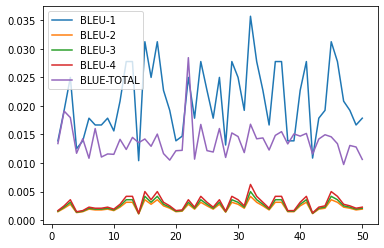

In [83]:
bleu_df.plot()

In [84]:
for col in bleu_df.columns:
    argmax = bleu_df[col].idxmax()
    print(col, argmax)

BLEU-1 32
BLEU-2 32
BLEU-3 32
BLEU-4 32
BLUE-TOTAL 22


 -> BLEU SCORE에 따르면 epoch 32에서 1,2,3,4 의 점수가 좋고 total은 22 에폭에서 제일 좋다

In [86]:
translates[32-1]

['마음 이 때문 에 마음 이 깊 을 거 예요 .', '마음 이 복잡 하 겠 어요 .', '인기 가 좋 으시 군요 .', '있 이 죠 .']

In [87]:
translates[22-1]

['큰 결심 이 네요 .', '이제 일어날 때 예요 .', '죠 .', '완전히 연애 죠 .']

-> 좋은 답인지 잘 모르겠다..

In [95]:
### 예문
print(f'예문')
print(' > 지루하다, 놀러가고 싶어.')
print(' > 오늘 일찍 일어났더니 피곤하다.')
print(' > 간만에 여자친구랑 데이트 하기로 했어.')
print(' > 집에 있는다는 소리야.\n')


### 제출
print(f'결과\n > {translates[13-1][0]}\n > {translates[13-1][1]}\n > {translates[13-1][2]}\n > {translates[13-1][3]}\n')

### Hyperparameters
print(f'Hyperparameters\n > n_layers: {N_LAYERS}\n > d_model: {D_MODEL}\n > n_heads: {N_HEADS}\n > d_ff: {D_FF}\n > dropout: {DROPOUT}\n')

### Training Parameters
print(f'Training Parameters\n > Warmup Steps: 1000\n > Batch Size: 64\n > > Epoch At: 13')

예문
 > 지루하다, 놀러가고 싶어.
 > 오늘 일찍 일어났더니 피곤하다.
 > 간만에 여자친구랑 데이트 하기로 했어.
 > 집에 있는다는 소리야.

결과
 > 저 랑 대화 하 고 싶 어요 .
 > 이제 일어날 시간 이 에요 .
 > 인기 가 필요 한 순간 이 네요 .
 > 같이 있 네요 .

Hyperparameters
 > n_layers: 2
 > d_model: 256
 > n_heads: 8
 > d_ff: 1024
 > dropout: 0.3

Training Parameters
 > Warmup Steps: 1000
 > Batch Size: 64
 > > Epoch At: 13


# 회고

- 배운 점 
    - transformer의 구조에 대해 좀 더 명확히 이해할 수 있었다
    - 숫자를 제거하는 전처리 제거만으로도 대답이 확연히 달라지는 것을 볼 수 있었다
- 아쉬운 점 
    - nan으로 계속 loss가 나와서 한참 시간을 썼다
    - 구조를 잘 이해하면 더 잘 해결하지 않았을까 아쉽다
- 느낀 점
    - 데이터 셋이 많아야하고 증강하는데도 더 의미있는 증강이 필요할 것 같다
- 어려웠던 점 
    - transformer의 구조를 이해하는데 어려웠다
    - loss function이나 전체적인 구조를 이해하기 어려웠다